### Making Dummy Data

In [2]:
import numpy as np
import sklearn
import xgboost
import hyperopt
import pandas as pd
import time

from skmultilearn.model_selection import IterativeStratification
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
from sklearn import datasets, pipeline
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

In [3]:
#Generating a multilabel classifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
X1, y1 = make_classification(n_features=50, n_samples=1000)
X2, y2 = make_classification(n_features=50, n_samples=1000)
X = np.concatenate((X1, X2), axis=1)
y = np.transpose([y2, y1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Building Simple XGBoost Bayesian Hyperparam Optimization

In [4]:
#Making sure I can use cross validation score with multilabel
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
myXGBC = OneVsRestClassifier(XGBClassifier(max_depth=3, subsample=0.5), n_jobs=2)
mean_score = cross_val_score(myXGBC, X, y, cv=5, scoring='roc_auc_ovr_weighted').mean()
mean_score

0.9505075537205316

In [5]:
#Define parameter space for hyperopt
xgbc_param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),          #1
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),                        #3
    'max_delta_step': scope.int(hp.quniform('max_delta_step', 0, 10, 1)),              #2
    'booster': hp.choice('booster', ['gbtree', 'dart']),                               #0
    'subsample': hp.uniform('subsample', 0.0, 1.0),                                    #7
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 150),                        #6
    'tree_method': hp.choice('tree_method', ['auto', 'hist']),                         #8
    'sampling_method': hp.choice('sampling_method', ['uniform', 'gradient_based']),    #5
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)                                   #4
}

In [6]:
#Defining the hyperopt function
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = OneVsRestClassifier(XGBClassifier(**params), n_jobs=2)
        #rocauc = []
        #k_fold = IterativeStratification(n_splits=5, order=2)
        #for train, test in k_fold.split(X_train, y_train):
        #    clf.fit(X_train[train], y_train[train])
        #    pred_probs = clf.predict_proba(X_train[test])
        #    rocauc.append(roc_auc_score(y_train[test], pred_probs, average='weighted'))
        #score = np.mean(rocauc)
        score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc_ovr_weighted').mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(23))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        booster = 'gbtree'
    else:
        booster = 'dart'
        
        
    if best_param_values[8] == 0:
        tree_method = 'auto'
    else:
        tree_method = 'hist'
        
    
    if best_param_values[5] == 0:
        sampling_method = 'uniform'
    else:
        sampling_method = 'gradient_based'
    
    clf_best = OneVsRestClassifier(XGBClassifier(learning_rate=best_param_values[1],
                                  max_depth=int(best_param_values[3]),
                                  max_delta_step=int(best_param_values[2]),
                                  booster=booster,
                                  subsample=best_param_values[7],
                                  scale_pos_weight = best_param_values[6],
                                  tree_method = tree_method,
                                  sampling_method = sampling_method,
                                  reg_lambda = best_param_values[4],
                                    
                                                 
                                ), n_jobs=2)
                                  
    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials


In [7]:
results_hyperopt_5 = hyperopt(xgbc_param_hyperopt, X_train, y_train, X_test, y_test, num_eval=5)

100%|██████████| 5/5 [01:00<00:00, 12.07s/trial, best loss: -0.9442888097122694]

##### Results
Score best parameters:  0.9442888097122694
Best parameters:  {'booster': 0, 'learning_rate': 0.31029248201887183, 'max_delta_step': 9.0, 'max_depth': 13.0, 'reg_lambda': 0.49265205078694607, 'sampling_method': 0, 'scale_pos_weight': 53.610470523135014, 'subsample': 0.9490718180842468, 'tree_method': 0}
Test Score:  0.815
Time elapsed:  61.87439179420471
Parameter combinations evaluated:  5


#### Pulling down hyperopt trials as a data frame

In [14]:
#Made function to turn it into dataframe
def hyperopt_make_df(hyperopt_results):
    score = []
    for trial in hyperopt_results.trials:
        #for item in trial['misc']['vals']:
            #print(item)
        if trial['tid'] < 1 :
            hyperopt_dict = {key : value for key, value in trial['misc']['vals'].items()}
        else:
            hyperopt_dict = {key : hyperopt_dict[key] + value for key, value in trial['misc']['vals'].items()}
        score.append(trial['result']['loss'])
    
    hyperopt_dict['score'] = score
    return pd.DataFrame(hyperopt_dict)

In [16]:
hyperopt_df = hyperopt_make_df(results_hyperopt_5)
hyperopt_df

,booster,learning_rate,max_delta_step,max_depth,reg_lambda,sampling_method,scale_pos_weight,subsample,tree_method,score
0,1,0.507276,5.0,10.0,0.711351,0,51.096741,0.736332,0,-0.938894
1,0,0.446530,10.0,6.0,0.182397,1,116.089382,0.602446,0,-0.921964
2,0,0.030935,6.0,14.0,0.907052,0,39.487262,0.933300,1,-0.939074
3,0,0.310292,9.0,13.0,0.492652,0,53.610471,0.949072,0,-0.944289
4,1,0.054451,8.0,8.0,0.058344,1,20.104711,0.459066,0,-0.903602


In [6]:
from sklearn import pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [35]:
#Set up pipeline
#pipe = pipeline.Pipeline([
#    ('clf', OneVsRestClassifier(XGBClassifier()))
#   ])
#Setting parameter space for random search
xgbc_param_random = {
    'estimator__learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 500, base=3)),          #1
    'estimator__max_depth': list(range(5, 15)),                        #3
    'estimator__max_delta_step': list(range(0, 13)),              #2
    'estimator__booster': ['gbtree', 'dart'],                               #0
    'estimator__subsample': list(np.linspace(0, 1, 500)),                                    #7
    'estimator__scale_pos_weight': list(range(1, 151)),                        #6
    'estimator__tree_method': ['auto', 'hist'],                         #8
    'estimator__sampling_method': ['uniform', 'gradient_based'],    #5
    'estimator__reg_lambda': list(np.linspace(0, 1, 500))                                   #4
}

model_to_set = OneVsRestClassifier(XGBClassifier())

In [31]:
def search(pipeline, parameters, X_train, y_train, X_test, y_test, optimizer='random_search', n_iter=None):
    

    
    if optimizer == 'random_search':
        grid_obj = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=parameters,
                            cv=5,
                            n_iter=n_iter,
                            refit=True,
                            return_train_score=False,
                            scoring = 'roc_auc_ovr_weighted',  #Gonna have to fix this if we want it stratified
                            random_state=1)
        grid_obj.fit(X_train, y_train,)
    
    else:
        print('enter search method')
        return

    estimator = grid_obj.best_estimator_
    cvs = cross_val_score(estimator, X_train, y_train, cv=5)
    results = pd.DataFrame(grid_obj.cv_results_)
    
    print("##### Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    print("Cross-validation Score: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ",results.shape[0])
    
    return results, estimator


In [40]:
model_tuning = RandomizedSearchCV(model_to_set,
                            param_distributions=xgbc_param_random,
                            cv=5,
                            n_iter=75,
                            refit=True,
                            return_train_score=False,
                            scoring = 'roc_auc_ovr_weighted',  #Gonna have to fix this if we want it stratified
                            random_state=1)

In [41]:
model_tuning.fit(X_train, y_train)
print(model_tuning.best_score_)
print(model_tuning.best_params_)

0.9697147164917299
{'estimator__tree_method': 'auto', 'estimator__subsample': 0.9478957915831663, 'estimator__scale_pos_weight': 61, 'estimator__sampling_method': 'gradient_based', 'estimator__reg_lambda': 0.43286573146292584, 'estimator__max_depth': 7, 'estimator__max_delta_step': 9, 'estimator__learning_rate': 0.17133003914674097, 'estimator__booster': 'gbtree'}


In [ ]:
results_random, estimator_random = search(pipe, xgbc_param_random, X_train, y_train, X_test, y_test, n_iter=75)

Ok so what it looks like is that alot of the stuff online provides a guide on how to pair the OneVsRestClassifier with the GridSearchCV rather than RandomizedSearch so we'll try to do that first

### Comparing the two hyperparameter searches for xgbc

In [48]:
#Retrieve Random Scores
results_random = pd.DataFrame(model_tuning.cv_results_)
random_scores = np.maximum.accumulate(results_random['mean_test_score']) #What is this?

#Retrieve Hyperopt scores
hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
hyperopt_scores = np.maximum.accumulate(hyperopt_scores)

In [ ]:
# Here is a full mimicry of what Mike does on github repo, so should work

f, ax = plt.subplots(figsize=(7,6))
sns.set_palette("husl")
sns.despine()
ax = sns.lineplot(x=[x for x in range(75)], y=random_scores, linewidth = 2)
ax = sns.lineplot(x=[x for x in range(75)], y=hyperopt_scores, linewidth = 2)
plt.title("Finding the optimum", fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cross-Validation Score (roc_auc_weighted, %)', fontsize=12)
plt.legend(loc='lower right', labels=['Random Search', 'Hyperopt'])
plt.setp(ax.get_legend().get_texts(), fontsize='12')


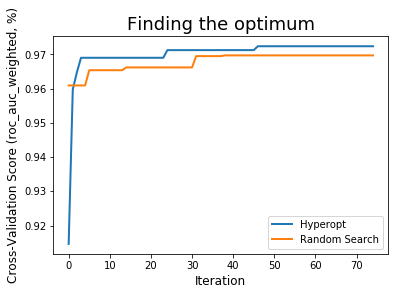

In [51]:
#Here is me trying to do it on my own
#%matplotlib inline

plt.plot(range(75), hyperopt_scores, linewidth = 2)
plt.plot(range(75), random_scores, linewidth = 2)
plt.title("Finding the optimum", fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cross-Validation Score (roc_auc_weighted, %)', fontsize=12)
plt.legend(loc='lower right', labels=['Hyperopt', 'Random Search'])
plt.show()

In [ ]:
#Plotting some other attribute Mike does learning rate and number of leaves

In [ ]:
#Plotting some other attribute

## Random Forest Classifier

### HyperOpt Parameter Search RFC

In [53]:
#Define parameter space for hyperopt
rfc_param_hyperopt= {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 50)),               #5
    'max_depth': scope.int(hp.quniform('max_depth', 5, 30, 1)),                         #1
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),         #4
        #Reallly want this above one to be on a doubling scale
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 2, 20, 2)),           #3                    
    'max_features': hp.uniform('max_features', 0.0, 1.0),                               #2    
    'class_weight': hp.choice('class_weight', ['balanced', 'balanced_subsample']),      #0                   
    }

In [59]:
#Defining the hyperopt function
def hyperopt_rfc(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = OneVsRestClassifier(RandomForestClassifier(**params), n_jobs=2)
        #rocauc = []
        #k_fold = IterativeStratification(n_splits=5, order=2)
        #for train, test in k_fold.split(X_train, y_train):
        #    clf.fit(X_train[train], y_train[train])
        #    pred_probs = clf.predict_proba(X_train[test])
        #    rocauc.append(roc_auc_score(y_train[test], pred_probs, average='weighted'))
        #score = np.mean(rocauc)
        score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc_ovr_weighted').mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(23))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        class_weight = 'balanced'
    else:
        class_weight = 'balanced_subsample'
        
    
    clf_best = OneVsRestClassifier(RandomForestClassifier(n_estimators=int(best_param_values[5]),
                                  max_depth=int(best_param_values[1]),
                                  min_samples_split=int(best_param_values[4]),
                                  class_weight=class_weight,
                                  min_samples_leaf=int(best_param_values[3]),
                                  max_features = best_param_values[2]
                                ), n_jobs=2)
                                  
    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials


In [61]:
rfc_results_hyperopt = hyperopt_rfc(rfc_param_hyperopt, X_train, y_train, X_test, y_test, num_eval=75)

100%|██████████| 75/75 [22:12<00:00, 17.77s/trial, best loss: -0.9706550731451695]

##### Results
Score best parameters:  0.9706550731451695
Best parameters:  {'class_weight': 1, 'max_depth': 11.0, 'max_features': 0.5589705885398194, 'min_samples_leaf': 18.0, 'min_samples_split': 4.0, 'n_estimators': 400.0}
Test Score:  0.875
Time elapsed:  1338.9520571231842
Parameter combinations evaluated:  75


### Randomized Parameter Search for RFC

In [4]:
rfc_param_random = {
    'estimator__n_estimators': list(range(100, 500, 50)),          #1
    'estimator__max_depth': list(range(5, 30)),                        #3
    'estimator__min_samples_split': list(range(2, 11)),              #2                              #0
    'estimator__min_samples_leaf': list(range(2, 20, 2)),                                    #7
    'estimator__max_features': list(np.linspace(0, 1, 20)),                        #6
    'estimator__class_weight': ['balanced', 'balanced_subsample']                                  #4
}

rfc_to_set = OneVsRestClassifier(RandomForestClassifier())

In [10]:
rfc_tuning = RandomizedSearchCV(rfc_to_set,
                            param_distributions=rfc_param_random,
                            cv=5,
                            n_iter=20,
                            refit=True,
                            return_train_score=False,
                            scoring = 'roc_auc_ovr_weighted',  #Gonna have to fix this if we want it stratified
                            random_state=23)

In [11]:
rfc_tuning.fit(X_train, y_train)
print(rfc_tuning.best_score_)
print(rfc_tuning.best_params_)

0.9819521797618505
{'estimator__n_estimators': 250, 'estimator__min_samples_split': 6, 'estimator__min_samples_leaf': 8, 'estimator__max_features': 0.42105263157894735, 'estimator__max_depth': 24, 'estimator__class_weight': 'balanced_subsample'}


### Randomized Parameter Search for RFC using Generator

In [12]:

k_fold = IterativeStratification(n_splits=5, order=1)
rfc_tuning_stratified = RandomizedSearchCV(rfc_to_set,
                            param_distributions=rfc_param_random,
                            cv=k_fold.split(X_train, y_train),
                            n_iter=5,
                            refit=True,
                            return_train_score=False,
                            scoring = 'roc_auc_ovr_weighted',  #Gonna have to fix this if we want it stratified
                            random_state=23)

In [13]:
rfc_tuning_stratified.fit(X_train, y_train)
print(rfc_tuning_stratified.best_score_)
print(rfc_tuning_stratified.best_params_)

0.9819800677258235
{'estimator__n_estimators': 150, 'estimator__min_samples_split': 3, 'estimator__min_samples_leaf': 10, 'estimator__max_features': 0.7368421052631579, 'estimator__max_depth': 28, 'estimator__class_weight': 'balanced_subsample'}


### Comparing the two hyperparameter searches for RFC

In [69]:
#Retrieve Random Scores
rfc_results_random = pd.DataFrame(rfc_tuning.cv_results_)
rfc_random_scores = np.maximum.accumulate(rfc_results_random['mean_test_score']) #What is this?

#Retrieve Hyperopt scores
rfc_hyperopt_scores = [trial['result']['loss']*-1 for trial in rfc_results_hyperopt.trials]
rfc_hyperopt_scores = np.maximum.accumulate(rfc_hyperopt_scores)

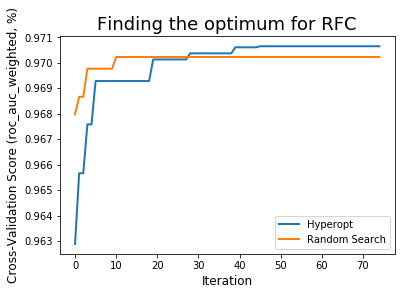

In [70]:
#Here is me trying to do it on my own
#%matplotlib inline

plt.plot(range(75), rfc_hyperopt_scores, linewidth = 2)
plt.plot(range(75), rfc_random_scores, linewidth = 2)
plt.title("Finding the optimum for RFC", fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cross-Validation Score (roc_auc_weighted, %)', fontsize=12)
plt.legend(loc='lower right', labels=['Hyperopt', 'Random Search'])
plt.show()